In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weathers/weather.csv
/kaggle/input/5001mh/train.csv
/kaggle/input/5001mh/test.csv


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import datetime

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head(10)

,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653
5,5,1/1/2017 5:00,46.797766
6,6,1/1/2017 6:00,44.404925
7,7,1/1/2017 7:00,45.255897
8,8,1/1/2017 8:00,45.680859
9,9,1/1/2017 9:00,48.435676


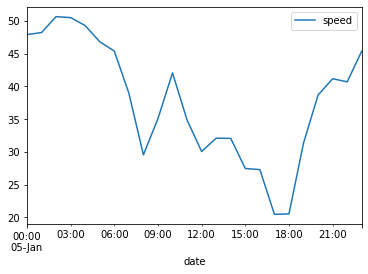

In [4]:
train.isna().value_counts()
train['date'] = pd.to_datetime(train['date'])
draw = train[(train['date'] < pd.to_datetime('1/6/2017')) & (train['date'] >= pd.to_datetime('1/5/2017'))]
draw.plot(x ='date', y='speed', kind = 'line')
plt.show()

In [5]:
#Hong Kong holidays
#taken from https://www.gov.hk/en/about/abouthk/holiday/2018.htm
public_vacation_list = [
    '20170102', '20170128', '20170130', '20170131', '20170404',
    '20170414', '20170415', '20170417', '20170501', '20170503',
    '20170530', '20170701', '20171002', '20171005', '20171028',
    '20171225', '20171226', '20180101', '20180216', '20180217',
    '20180219', '20180330', '20180331', '20180402', '20180405',
    '20180501', '20180522', '20180618', '20180702', '20180925',
    '20181001', '20181017', '20181225', '20181226'
]

In [6]:
weather = pd.read_csv('weather.csv')
print(weather)

     year  month  day  MaxTemp  MinTemp  isRain
0    2017      1    1     20.8     18.4       0
1    2017      1    2     23.3     18.4       0
2    2017      1    3     21.3     18.9       0
3    2017      1    4     21.7     18.7       0
4    2017      1    5     23.4     18.9       0
..    ...    ...  ...      ...      ...     ...
725  2018     12   27     22.8     18.9       0
726  2018     12   28     20.2     16.3       0
727  2018     12   29     16.3     12.5       0
728  2018     12   30     15.4     10.3       0
729  2018     12   31     15.6     11.8       0

[730 rows x 6 columns]


In [7]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['hour'] = train['date'].dt.hour
train['weekday']=train['date'].dt.dayofweek
train['quarter'] = train['date'].dt.quarter
train['dayofyear'] = train['date'].dt.dayofyear
train['weekofyear'] = train['date'].dt.week
train['isBusyHour'] =train['date'].dt.time.apply(lambda x: 0 if \
                                                 datetime.time(0) <= x <= datetime.time(6) \
                                                 or datetime.time(20) <= x <= datetime.time(23) else 1)
train['is_public_holiday'] = train['date'].apply(lambda x: 1 if x in public_vacation_list else 0)
del train['id']
print(train)

                     date      speed  year  month  day  hour  weekday  \
0     2017-01-01 00:00:00  43.002930  2017      1    1     0        6   
1     2017-01-01 01:00:00  46.118696  2017      1    1     1        6   
2     2017-01-01 02:00:00  44.294158  2017      1    1     2        6   
3     2017-01-01 03:00:00  41.067468  2017      1    1     3        6   
4     2017-01-01 04:00:00  46.448653  2017      1    1     4        6   
...                   ...        ...   ...    ...  ...   ...      ...   
14001 2018-12-31 12:00:00  19.865269  2018     12   31    12        0   
14002 2018-12-31 15:00:00  17.820375  2018     12   31    15        0   
14003 2018-12-31 16:00:00  12.501851  2018     12   31    16        0   
14004 2018-12-31 18:00:00  15.979319  2018     12   31    18        0   
14005 2018-12-31 20:00:00  40.594183  2018     12   31    20        0   

       quarter  dayofyear  weekofyear  isBusyHour  is_public_holiday  
0            1          1          52           0   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [8]:
train = pd.merge(train,weather,on=['year','month', 'day'])
print(train)

                     date      speed  year  month  day  hour  weekday  \
0     2017-01-01 00:00:00  43.002930  2017      1    1     0        6   
1     2017-01-01 01:00:00  46.118696  2017      1    1     1        6   
2     2017-01-01 02:00:00  44.294158  2017      1    1     2        6   
3     2017-01-01 03:00:00  41.067468  2017      1    1     3        6   
4     2017-01-01 04:00:00  46.448653  2017      1    1     4        6   
...                   ...        ...   ...    ...  ...   ...      ...   
14001 2018-12-31 12:00:00  19.865269  2018     12   31    12        0   
14002 2018-12-31 15:00:00  17.820375  2018     12   31    15        0   
14003 2018-12-31 16:00:00  12.501851  2018     12   31    16        0   
14004 2018-12-31 18:00:00  15.979319  2018     12   31    18        0   
14005 2018-12-31 20:00:00  40.594183  2018     12   31    20        0   

       quarter  dayofyear  weekofyear  isBusyHour  is_public_holiday  MaxTemp  \
0            1          1          52     

In [9]:
X = train.copy()
del X['speed']
del X['date']
y = train['speed']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)
print(X_train)
print(y_train)

       year  month  day  hour  weekday  quarter  dayofyear  weekofyear  \
5888   2017      3    9    18        3        1         68          10   
9565   2018      2   25    12        6        1         56           8   
3429   2017      5   24     6        2        2        144          21   
13856  2018     12   20    21        3        4        354          51   
7801   2017     11   22    11        2        4        326          47   
...     ...    ...  ...   ...      ...      ...        ...         ...   
9811   2018      3   14     5        2        1         73          11   
5078   2017      1    8     0        6        1          8           1   
3310   2017      5   19     7        4        2        139          20   
12047  2018     11    8    15        3        4        312          45   
13189  2018      1   11    18        3        1         11           2   

       isBusyHour  is_public_holiday  MaxTemp  MinTemp  isRain  
5888            1                  0     19.6 

In [11]:
# This is the final model
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgbr = xgb.XGBRegressor(learning_rate=0.05,
                         n_estimators=410,
                         max_depth=19,
                         min_child_weight=4.1,
                         seed=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         gamma=0.3,
                         reg_alpha=23,
                         reg_lambda=0.05)
xgb_param = xgbr.get_xgb_params()

print('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, nfold=5, metrics=['rmse'])
print('Best number of trees = {}'.format(cvresult.shape[0]))
xgbr.fit(X_train, y_train, eval_metric='rmse')
y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

Start cross validation
Best number of trees = 10
MSE: 12.75


In [171]:
# this is the parameters optimization process
cv_params = {'colsample_bytree': [0.6, 0.65, 0.70, 0.75, 0.76]}
other_params = {'objective': 'reg:squarederror',
                'learning_rate': 0.05,
                'n_estimators': 410,
                'max_depth': 19,
                'min_child_weight': 4.1,
                'seed': 0,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'gamma': 0.3,
                'reg_alpha': 23,
                'reg_lambda': 0.05,
                'subsample': 0.8,
                'colsample_bytree': 0.7}

model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params,
                             scoring='r2', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
#evalute_result = optimized_GBM.cv_scores_
#print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.2min finished


参数的最佳取值：{'colsample_bytree': 0.7}
最佳模型得分:0.9210034899347066


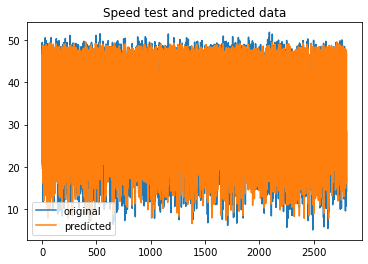

In [12]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Speed test and predicted data")
plt.legend()
plt.show()

In [13]:
testid = test.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['hour'] = test['date'].dt.hour
test['weekday']=test['date'].dt.dayofweek
test['quarter'] = test['date'].dt.quarter
test['dayofyear'] = test['date'].dt.dayofyear
test['weekofyear'] = test['date'].dt.week
test['isBusyHour'] =test['date'].dt.time.apply(lambda x: 0 if \
                                                 datetime.time(0) <= x <= datetime.time(6) \
                                                 or datetime.time(20) <= x <= datetime.time(23) else 1)
test['is_public_holiday'] = train['date'].apply(lambda x: 1 if x in public_vacation_list else 0)
test = pd.merge(test, weather,on=['year','month', 'day'])
del test['date']
del test['id']
print(test)

      year  month  day  hour  weekday  quarter  dayofyear  weekofyear  \
0     2018      1    1     2        0        1          1           1   
1     2018      1    1     5        0        1          1           1   
2     2018      1    1     7        0        1          1           1   
3     2018      1    1     8        0        1          1           1   
4     2018      1    1    10        0        1          1           1   
...    ...    ...  ...   ...      ...      ...        ...         ...   
3499  2018     12   31    17        0        4        365           1   
3500  2018     12   31    19        0        4        365           1   
3501  2018     12   31    21        0        4        365           1   
3502  2018     12   31    22        0        4        365           1   
3503  2018     12   31    23        0        4        365           1   

      isBusyHour  is_public_holiday  MaxTemp  MinTemp  isRain  
0              0                  0     19.0     16.3      

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
result = xgbr.predict(test)
output = pd.DataFrame(result, columns = ['speed'])
submission=pd.concat([testid['id'],output],axis=1)
print(submission)
print(submission.shape)

        id      speed
0        0  47.532520
1        1  47.651871
2        2  34.934437
3        3  28.207491
4        4  35.279095
...    ...        ...
3499  3499  12.185925
3500  3500  25.204300
3501  3501  44.415489
3502  3502  39.550865
3503  3503  42.409000

[3504 rows x 2 columns]
(3504, 2)


In [178]:
submission.to_csv('result4.csv',index=False)